#cambio y aplicar cambios en VM

# Título  Optimización de hiperparámetros
## Autor: Jose Chelquer
## Fecha de última modificación: 21/11/2024

Hace optimización de hiperparámetros y los graba



## Parámetros

< Descripción de cada uno de los parámetros que utiliza el job >


In [370]:
experimento="sp__"                        # sampleado, preprocesado feat simple
tipo_registros=experimento[0]            # '_'completo s sampleado
con_preprocesamiento = experimento[1]    # p con preprocesamiento  '_' sin preprocesamiento
tipo_featuring=experimento[2]            # _: 155 base  s: simple    c: completo
rf=experimento[3]                        # _: sin RF   r: con RF

dict_tipo_registros={'_': 'completo', 's': 'sampleado'}
dict_con_preprocesamiento={'_': 'sin preprocesamiento', 'p':'con preprocesamiento'}
dict_tipo_featuring={'_': 'base', 's':' simple', 'c': 'completo'}
dict_rf={'_': 'sin RF', 'f':' con RF'}

print (f'Experimento {experimento}')
print (dict_tipo_registros[tipo_registros])
print (dict_con_preprocesamiento[con_preprocesamiento])
print (dict_tipo_featuring[tipo_featuring])
print (dict_rf[rf])

Experimento sp__
sampleado
con preprocesamiento
base
sin RF


In [371]:
# vm o local?
vm=True
if vm:
  usar_gdrive=False
else:
  usar_gdrive=True      #se va a usar google dirve


In [372]:
semillas=[101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197]

ganancia_acierto=273000
costo_estimulo=7000

In [373]:
# meses de entrenamiento, evaluación y test
if vm:
#  mes_train_desde = 202101
  mes_train_desde= 202101
  mes_train_hasta = 202106
  mes_test = 202108
else:
  mes_train_desde = 202104
  mes_train_hasta = 202106
  mes_test = 202108

In [374]:
study_name=f"optimizacion_{experimento}_lgb"

In [375]:
if vm:
    n_trials=15
else:
    n_trials=25

# parámetros del lgb a optimizar
params=[
    ['num_leaves', 'int', [8,500]],
    ['learning_rate', 'float', [0.005, 0.3]],
    ['min_data_in_leaf','int', [1, 1500]],
    ['feature_fraction', 'float',[0.1, 1.0]],
    ['bagging_fraction', 'float',[0.05, 0.5  ]]

]

params_fijos={
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'early_stopping':50,
        'max_bin': 31
}
lgb_verbosity=-1
num_boost_round=1000

#grabar_importancias=True          # Se puede pedir que grabe las importancias de variables como resultado secundario
grabar_importancias=False

importancias_file=f'importancias_lgb{experimento}.csv.gz'


In [376]:
# parámetros de envío a kaggle
version = f'202_{experimento}_'
prefijo_envio="j010_lgb_{experimento}_"
enviar_desde=7000
enviar_hasta=16000
cant_envios=10            #Cantidad de envíos a Kaggle


## Input

< Archivos de datos (csv.gz) con sus paths que van a consumirse por el job>

In [377]:
# EL script se adapta a archivos .csv o .csv.gz
if vm:
  dataset_path = '/home/jose/buckets/b1/datasets'
  kaggle_json_path="/home/jose/buckets/b1"
  dataset_file=f'k2_{tipo_registros}{con_preprocesamiento}{tipo_featuring}{rf}.parquet.gz'

else:
  dataset_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/datasets/'
  kaggle_json_path="/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas"
  dataset_file=f'k2_{tipo_registros}{con_preprocesamiento}{tipo_featuring}{rf}.parquet.gz'

print (dataset_path)
print (dataset_file)

/home/jose/buckets/b1/datasets
k2_sp__.parquet.gz


## Output

< Archivos, bases de datos, modelos que va a generar el job>

In [378]:

if vm:
  db_path='/home/jose/buckets/b1/db'
  modelos_path='/home/jose/buckets/b1/modelos'

else:
  db_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/db/'
        # optuna no puede hacerlo en drive.  La copia se hará al final, si se puede
  modelos_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/modelos/'

modelos_file=f'lgb_optimizado_{experimento}'
params_file=f"best_params"

## Procesos

### Paquetes necesarios

In [379]:
#%pip install optuna==3.6.1
%pip install optuna==4.0

Note: you may need to restart the kernel to use updated packages.


## Código del proceso

< Todo el código a partir de aquí debe poder ejecutarse sin necesidad de parametrizar nada>

Instalamos, cargamos y seteamos el entorno

## Gdrive?

In [380]:
if usar_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

## Librerías

In [381]:
!pip install --upgrade pip
!pip install --upgrade lightgbm
!pip install dask[dataframe]

In [382]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

import json

from time import time

import pickle



## Leer datos

In [383]:
semilla=semillas[2]


In [384]:
def contabilizar(df, descripción):
  print (f'\nContabilización de la base {descripción}\n')
  print (f'\nShape: {df.shape}\n')
  n_vars=len(df.columns)
  n_vars_tree=len([col for col in df.columns if col.startswith('tree')])
  print (f"Variables: {n_vars}")
  print (f"Variables tree: {n_vars_tree}")
  print (f"\nFilas por mes: \n{df['foto_mes'].value_counts()}\n")
  if 'clase_ternaria' in df.columns:
    print (f"\nFilas por mes y clase: \n{pd.crosstab(df['foto_mes'], df['clase_ternaria'])}\n")
def cant_meses(df):
  return len(df['foto_mes'].unique())

In [385]:
if 'parquet' in dataset_file:
    data = pd.read_parquet(os.path.join(dataset_path, dataset_file))
else:
    data = pd.read_csv(os.path.join(dataset_path, dataset_file))

if 'clase_ternaria_num' in data.columns:
  data = data.drop(columns=['clase_ternaria_num'])

In [386]:
dataset_path

'/home/jose/buckets/b1/datasets'

In [387]:

contabilizar(data, 'Datos Leídos '+ dataset_file)


Contabilización de la base Datos Leídos k2_sp__.parquet.gz


Shape: (375309, 155)

Variables: 155
Variables tree: 0

Filas por mes: 
foto_mes
202108    165442
202104     18363
202105     18352
202106     18271
202103     18169
202102     17886
202101     17481
202012     17307
202011     17097
202010     16921
202009     16771
202007     16629
202008     16620
Name: count, dtype: int64


Filas por mes y clase: 
clase_ternaria  BAJA+1  BAJA+2  CONTINUA
foto_mes                                
202007             627     542     15460
202008             544     472     15604
202009             474     564     15733
202010             565     488     15868
202011             490     646     15961
202012             649     634     16024
202101             635     785     16061
202102             785    1017     16084
202103            1020     981     16168
202104             982    1189     16192
202105            1189     911     16252
202106             908    1074     16289
202108    

In [388]:
data.columns

Index(['numero_de_cliente', 'foto_mes', 'active_quarter', 'cliente_vip',
       'internet', 'cliente_edad', 'cliente_antiguedad', 'mrentabilidad',
       'mrentabilidad_annual', 'mcomisiones',
       ...
       'Visa_fultimo_cierre', 'Visa_mpagado', 'Visa_mpagospesos',
       'Visa_mpagosdolares', 'Visa_fechaalta', 'Visa_mconsumototal',
       'Visa_cconsumos', 'Visa_cadelantosefectivo', 'Visa_mpagominimo',
       'clase_ternaria'],
      dtype='object', length=155)

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [389]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [390]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

## Preparar train y test

In [391]:
print ("Separando train")
train_data = data[(data['foto_mes'] >= mes_train_desde)&(data['foto_mes'] <= mes_train_hasta)]

print ("Separando X_train y_train etc.")
X_train = train_data.drop(['clase_ternaria','clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']
y_train = y_train_binaria2
print ("Separados")

Separando train
Separando X_train y_train etc.
Separados


In [392]:
contabilizar(X_train, "Datos de entrenamiento")


Contabilización de la base Datos de entrenamiento


Shape: (108522, 154)

Variables: 154
Variables tree: 0

Filas por mes: 
foto_mes
202104    18363
202105    18352
202106    18271
202103    18169
202102    17886
202101    17481
Name: count, dtype: int64



# Optimizar

 ## cáclulo de ganancias

In [393]:
# La función de evaluacion para Optuna SIEMPRE debe tener estos dos parámetros:
#  los datos predichos y los datos sobre los que se predijo, porque esto es lo que le manda
#  optuna
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    # Diferencia si erban BAJA+1 o BAJA+2
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    #Ordena ganancia según los índices ordenados de y_pred de mayor a menor
    ganancia = ganancia[np.argsort(y_pred)[::-1]] #: desde todo : hasta todo :-1 step hacia atrás
    # Ganancias acumuladas so far
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True


# Para calcular ganancias fuera del proceso de optimización:
def ganancias_obtenidas(y_pred, X, weight):
    n_meses=cant_meses(X)
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    #Ordena ganancia según los índices ordenados de y_pred de mayor a menor
    ganancia = ganancia[np.argsort(y_pred)[::-1]] #: desde todo : hasta todo :-1 step hacia atrás
    # Ganancias acumuladas so far
    ganancia = np.cumsum(ganancia)
    ganancia_maxima=max(ganancia)
    cant_envios = np.argmax(ganancia) + 1  # Sumar 1 para tener la posición en términos de "cantidad"

    return np.round(ganancia/n_meses/1000), np.round(ganancia_maxima/n_meses/1000), cant_envios



## Función objetivo para optuna

In [394]:
def suggest_params(trial, params):
    suggested_params = {}
    for param in params:
        name, param_type, range_values = param
        if param_type == 'int':
            suggested_params[name] = trial.suggest_int(name, *range_values)
        elif param_type == 'float':
            suggested_params[name] = trial.suggest_float(name, *range_values)
    return suggested_params

def objective(trial):
    suggested_params = suggest_params(trial, params)
    train_data = lgb.Dataset(X_train,
                              label=y_train, # eligir la clase
                              weight=w_train)
    combined_params = {**suggested_params, **params_fijos, "verbosity": lgb_verbosity}
    print (f"Calculando resultados lgb  {combined_params}")
    seed=semillas[0]
    cv_results = lgb.cv(
        combined_params,
        num_boost_round=num_boost_round,
        seed=semilla,
        train_set=train_data,
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,              #no lo muestra en el log pero lo está haciendo
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)
    return max_gan * 5    # Son 5 k-folds... parece que es por eso.


## Crear/cargar estudio y ejecutarlo

In [395]:
#crea el estudio
modo_log=False
if modo_log:
    if vm:
      db_grabada=os.path.join(db_path, study_name)+".log"
      storage_name = JournalStorage(JournalFileBackend(os.path.join(db_path, study_name)+".log"))
    else:
      db_grabada=os.path.join(db_path, study_name)+".log"
      storage_name = JournalStorage(JournalFileBackend(os.path.join('/content', study_name)+".log"))
else:
    if vm:
      db_grabada=os.path.join(db_path, study_name)+".db"
      storage_name = "sqlite:///" + db_grabada
    else:
      db_grabada=os.path.join(db_path, study_name)+".db"
      storage_name = "sqlite:///" + '/content/'+ study_name+'.db'
 


print (f'Haciendo el estudio {study_name}')
study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

Haciendo el estudio optimizacion_sp___lgb


[I 2024-11-24 23:34:20,822] Using an existing study with name 'optimizacion_sp___lgb' instead of creating a new one.


In [396]:
storage_name

'sqlite:////home/jose/buckets/b1/db/optimizacion_sp___lgb.db'

In [397]:
print (f'OPTUNA con {n_trials} intentos')
study.optimize(objective, n_trials=n_trials) # subir subir


OPTUNA con 15 intentos
Calculando resultados lgb  {'num_leaves': 370, 'learning_rate': 0.133438037904611, 'min_data_in_leaf': 248, 'feature_fraction': 0.4552389424416705, 'bagging_fraction': 0.43499810162253305, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:35:18,238] Trial 15 finished with value: 1334592000.0 and parameters: {'num_leaves': 370, 'learning_rate': 0.133438037904611, 'min_data_in_leaf': 248, 'feature_fraction': 0.4552389424416705, 'bagging_fraction': 0.43499810162253305}. Best is trial 15 with value: 1334592000.0.


Calculando resultados lgb  {'num_leaves': 498, 'learning_rate': 0.09297653574385874, 'min_data_in_leaf': 276, 'feature_fraction': 0.5952576884933904, 'bagging_fraction': 0.31484705967353066, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:37:06,991] Trial 16 finished with value: 1340661000.0 and parameters: {'num_leaves': 498, 'learning_rate': 0.09297653574385874, 'min_data_in_leaf': 276, 'feature_fraction': 0.5952576884933904, 'bagging_fraction': 0.31484705967353066}. Best is trial 16 with value: 1340661000.0.


Calculando resultados lgb  {'num_leaves': 496, 'learning_rate': 0.08715209987858354, 'min_data_in_leaf': 312, 'feature_fraction': 0.36580882323379527, 'bagging_fraction': 0.3010222564037162, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:38:02,380] Trial 17 finished with value: 1329867000.0 and parameters: {'num_leaves': 496, 'learning_rate': 0.08715209987858354, 'min_data_in_leaf': 312, 'feature_fraction': 0.36580882323379527, 'bagging_fraction': 0.3010222564037162}. Best is trial 16 with value: 1340661000.0.


Calculando resultados lgb  {'num_leaves': 491, 'learning_rate': 0.09089222494459157, 'min_data_in_leaf': 807, 'feature_fraction': 0.565132990651962, 'bagging_fraction': 0.33536603988677427, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:39:18,651] Trial 18 finished with value: 1331680000.0 and parameters: {'num_leaves': 491, 'learning_rate': 0.09089222494459157, 'min_data_in_leaf': 807, 'feature_fraction': 0.565132990651962, 'bagging_fraction': 0.33536603988677427}. Best is trial 16 with value: 1340661000.0.


Calculando resultados lgb  {'num_leaves': 252, 'learning_rate': 0.15170051409533325, 'min_data_in_leaf': 991, 'feature_fraction': 0.10758402501238012, 'bagging_fraction': 0.25250204002939036, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:40:09,030] Trial 19 finished with value: 1316399000.0 and parameters: {'num_leaves': 252, 'learning_rate': 0.15170051409533325, 'min_data_in_leaf': 991, 'feature_fraction': 0.10758402501238012, 'bagging_fraction': 0.25250204002939036}. Best is trial 16 with value: 1340661000.0.


Calculando resultados lgb  {'num_leaves': 395, 'learning_rate': 0.06358049894856736, 'min_data_in_leaf': 326, 'feature_fraction': 0.46899707469697877, 'bagging_fraction': 0.4200155318692179, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:41:33,264] Trial 20 finished with value: 1339275000.0 and parameters: {'num_leaves': 395, 'learning_rate': 0.06358049894856736, 'min_data_in_leaf': 326, 'feature_fraction': 0.46899707469697877, 'bagging_fraction': 0.4200155318692179}. Best is trial 16 with value: 1340661000.0.


Calculando resultados lgb  {'num_leaves': 391, 'learning_rate': 0.06595956444545298, 'min_data_in_leaf': 411, 'feature_fraction': 0.46823980180319547, 'bagging_fraction': 0.4283273654989405, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:42:40,023] Trial 21 finished with value: 1333577000.0 and parameters: {'num_leaves': 391, 'learning_rate': 0.06595956444545298, 'min_data_in_leaf': 411, 'feature_fraction': 0.46823980180319547, 'bagging_fraction': 0.4283273654989405}. Best is trial 16 with value: 1340661000.0.


Calculando resultados lgb  {'num_leaves': 308, 'learning_rate': 0.11915181042419198, 'min_data_in_leaf': 187, 'feature_fraction': 0.2981169715485943, 'bagging_fraction': 0.41978007209738966, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:43:53,564] Trial 22 finished with value: 1337063000.0 and parameters: {'num_leaves': 308, 'learning_rate': 0.11915181042419198, 'min_data_in_leaf': 187, 'feature_fraction': 0.2981169715485943, 'bagging_fraction': 0.41978007209738966}. Best is trial 16 with value: 1340661000.0.


Calculando resultados lgb  {'num_leaves': 302, 'learning_rate': 0.07185627428326452, 'min_data_in_leaf': 151, 'feature_fraction': 0.2951079363206765, 'bagging_fraction': 0.4002661715442807, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:45:22,371] Trial 23 finished with value: 1336951000.0 and parameters: {'num_leaves': 302, 'learning_rate': 0.07185627428326452, 'min_data_in_leaf': 151, 'feature_fraction': 0.2951079363206765, 'bagging_fraction': 0.4002661715442807}. Best is trial 16 with value: 1340661000.0.


Calculando resultados lgb  {'num_leaves': 230, 'learning_rate': 0.11766287312318813, 'min_data_in_leaf': 388, 'feature_fraction': 0.787970157349255, 'bagging_fraction': 0.3457793293111259, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:46:14,431] Trial 24 finished with value: 1332450000.0 and parameters: {'num_leaves': 230, 'learning_rate': 0.11766287312318813, 'min_data_in_leaf': 388, 'feature_fraction': 0.787970157349255, 'bagging_fraction': 0.3457793293111259}. Best is trial 16 with value: 1340661000.0.


Calculando resultados lgb  {'num_leaves': 447, 'learning_rate': 0.1113753136238731, 'min_data_in_leaf': 673, 'feature_fraction': 0.3632863136999127, 'bagging_fraction': 0.29561678977319833, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:47:29,499] Trial 25 finished with value: 1330868000.0 and parameters: {'num_leaves': 447, 'learning_rate': 0.1113753136238731, 'min_data_in_leaf': 673, 'feature_fraction': 0.3632863136999127, 'bagging_fraction': 0.29561678977319833}. Best is trial 16 with value: 1340661000.0.


Calculando resultados lgb  {'num_leaves': 301, 'learning_rate': 0.16254144803109485, 'min_data_in_leaf': 148, 'feature_fraction': 0.6044764018208973, 'bagging_fraction': 0.2130254851611041, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:49:07,952] Trial 26 finished with value: 1342138000.0 and parameters: {'num_leaves': 301, 'learning_rate': 0.16254144803109485, 'min_data_in_leaf': 148, 'feature_fraction': 0.6044764018208973, 'bagging_fraction': 0.2130254851611041}. Best is trial 26 with value: 1342138000.0.


Calculando resultados lgb  {'num_leaves': 407, 'learning_rate': 0.18736931951591965, 'min_data_in_leaf': 444, 'feature_fraction': 0.588755832453378, 'bagging_fraction': 0.16345723477798635, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:50:15,746] Trial 27 finished with value: 1333451000.0 and parameters: {'num_leaves': 407, 'learning_rate': 0.18736931951591965, 'min_data_in_leaf': 444, 'feature_fraction': 0.588755832453378, 'bagging_fraction': 0.16345723477798635}. Best is trial 26 with value: 1342138000.0.


Calculando resultados lgb  {'num_leaves': 201, 'learning_rate': 0.1548145853832773, 'min_data_in_leaf': 194, 'feature_fraction': 0.6345004622800703, 'bagging_fraction': 0.20392420350033386, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:51:05,131] Trial 28 finished with value: 1336923000.0 and parameters: {'num_leaves': 201, 'learning_rate': 0.1548145853832773, 'min_data_in_leaf': 194, 'feature_fraction': 0.6345004622800703, 'bagging_fraction': 0.20392420350033386}. Best is trial 26 with value: 1342138000.0.


Calculando resultados lgb  {'num_leaves': 337, 'learning_rate': 0.006227103891531381, 'min_data_in_leaf': 1182, 'feature_fraction': 0.5418288297761711, 'bagging_fraction': 0.250897500752489, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'early_stopping': 50, 'max_bin': 31, 'verbosity': -1}


[I 2024-11-24 23:52:48,748] Trial 29 finished with value: 1300530000.0 and parameters: {'num_leaves': 337, 'learning_rate': 0.006227103891531381, 'min_data_in_leaf': 1182, 'feature_fraction': 0.5418288297761711, 'bagging_fraction': 0.250897500752489}. Best is trial 26 with value: 1342138000.0.


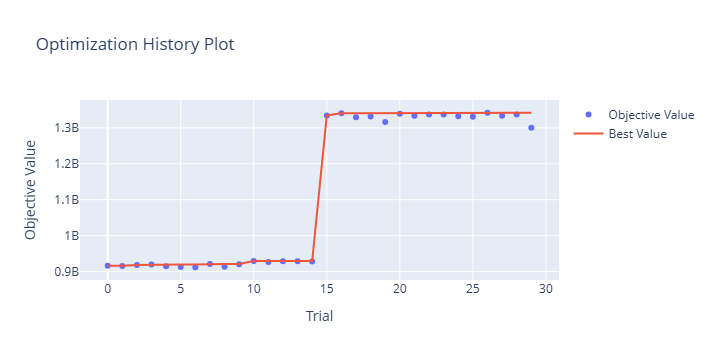

In [398]:
optuna.visualization.plot_optimization_history(study)

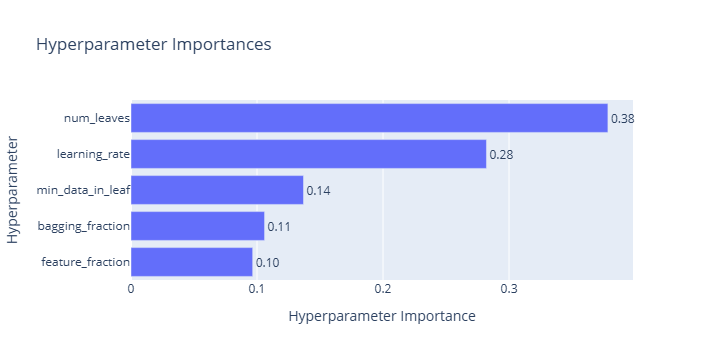

In [399]:
plot_param_importances(study)

In [400]:
plot_slice(study)

In [401]:
plot_contour(study)

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [402]:
# Entreno con el mejor modelo
best_params = study.best_params
print (best_params)

best_iter = study.best_trial.user_attrs["best_iter"]
print()
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")

print()
print ('Parámetros combinados')
combined_params = {**best_params, **params_fijos, "verbosity": lgb_verbosity}
del combined_params['early_stopping']
print (combined_params)
  

{'num_leaves': 301, 'learning_rate': 0.16254144803109485, 'min_data_in_leaf': 148, 'feature_fraction': 0.6044764018208973, 'bagging_fraction': 0.2130254851611041}

Mejor cantidad de árboles para el mejor model 472

Parámetros combinados
{'num_leaves': 301, 'learning_rate': 0.16254144803109485, 'min_data_in_leaf': 148, 'feature_fraction': 0.6044764018208973, 'bagging_fraction': 0.2130254851611041, 'objective': 'binary', 'metric': 'custom', 'boosting_type': 'gbdt', 'first_metric_only': True, 'boost_from_average': True, 'feature_pre_filter': False, 'max_bin': 31, 'verbosity': -1}


In [403]:
print ("Entrenando el modelo con X_train")


train_data = lgb.Dataset(X_train,
                          label=y_train,
                          weight=w_train)

model = lgb.train(combined_params,
                  train_set=train_data,
                  num_boost_round=best_iter
                  )
print ("Fin del entrenamiento")


Entrenando el modelo con X_train
Fin del entrenamiento


### Guardar los params o para poder utilizarlo más adelante

In [404]:
output_path=f'{os.path.join(modelos_path, params_file)}.json'
print (f'Guardando best params en {output_path}')

# Guardar los parámetros en un archivo JSON
with open(output_path, "w") as file:
    json.dump(best_params, file)

print(f"Parámetros guardados en {output_path}")

Guardando best params en /home/jose/buckets/b1/modelos/best_params.json
Parámetros guardados en /home/jose/buckets/b1/modelos/best_params.json


# Guardar el modelo: IMPORTANTE

In [405]:
print (f'Guardando modelo en {os.path.join(modelos_path, modelos_file)}.txt')
path_modelo=os.path.join(modelos_path, modelos_file)+'.txt'
print (f'EL modelo guardado: {modelos_file}\n')
print (f'path: {path_modelo}')
model.save_model(path_modelo)

Guardando modelo en /home/jose/buckets/b1/modelos/lgb_optimizado_sp__.txt
EL modelo guardado: lgb_optimizado_sp__

path: /home/jose/buckets/b1/modelos/lgb_optimizado_sp__.txt
